# SimCLR Tests with Flowers Dataset

Resources:

- [SimCLR](https://arxiv.org/abs/2002.05709)
- [Official SimCLR repository](https://github.com/google-research/simclr)
- [Amit Chaudhary's blog on SimCLR](https://amitness.com/2020/03/illustrated-simclr/)
- [Sayak Paul's blog on SimCLR](https://wandb.ai/sayakpaul/simclr/reports/Towards-Self-Supervised-Image-Understanding-with-SimCLR--VmlldzoxMDI5NDM)
- [sthalles' SimCLR implementation in PyTorch](https://github.com/sthalles/SimCLR)
- [SimCLR at Kaggle](https://www.kaggle.com/code/aritrag/simclr)
- [**Flowers Dataset at Kaggle**](https://www.kaggle.com/datasets/imsparsh/flowers-dataset)

Table of contents:

- [GPU Setup](#GPU-Setup)
- [Config](#Config)
- [Dataset and Stochastic Augmentation](#Dataset-and-Stochastic-Augmentation)
- [SimCLR Model](#SimCLR-Model)
- [Utils](#Utils)
- [Contrastive Loss and Training](#Contrastive-Loss-and-Training)
- [Downstream Evaluation: Linear Classification Model](#Downstream-Evaluation:-Linear-Classification-Model)
- [Downstream Evaluation: Similarity Distributions](#Downstream-Evaluation:-Similarity-Distributions)
    - Generation of embedding vector dataset
    - K-Means clustering
    - T-SNE visualizations
    - PCA
    - Similarity distributions

In [1]:
import os
import glob
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from torch.utils.data import (
    Dataset,
    DataLoader,
)

from torchvision.datasets import ImageFolder
from torchvision.transforms import (
    RandomResizedCrop,
    RandomHorizontalFlip,
    RandomVerticalFlip,
    ColorJitter,
    RandomGrayscale,
    RandomApply,
    Compose,
    GaussianBlur,
    ToTensor,
    Normalize,
    CenterCrop,
    Resize
)
import torchvision.models as models
from torch.optim.lr_scheduler import StepLR

import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from PIL import Image
import seaborn as sns
import pandas as pd
import ast
import cv2

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_curve
from sklearn.decomposition import PCA

## GPU Setup

In [2]:
torch.__version__
# '1.13.0+cu117'

'1.13.0+cu117'

In [3]:
# Get info of all GPU devices
!nvidia-smi

Fri Jul 14 16:36:34 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.23                 Driver Version: 536.23       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  | 00000000:22:00.0 Off |                  N/A |
|  0%   38C    P8              14W / 170W |    180MiB / 12288MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
# Set environment variable with possible device ids
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
print(os.environ["CUDA_VISIBLE_DEVICES"])
# Set device: 0 or 1
# NOTE: indices are not necessarily the ones shown by nvidia-smi
# We need to try them with the cell below
torch.cuda.set_device("cuda:0")

0,1


In [5]:
# Check that the selected device is the desired one
print("Torch version?", torch.__version__)
print("Torchvision version?", torchvision.__version__)
print("Is cuda available?", torch.cuda.is_available())
print("Is cuDNN version:", torch.backends.cudnn.version())
print("cuDNN enabled? ", torch.backends.cudnn.enabled)
print("Device count?", torch.cuda.device_count())
print("Current device?", torch.cuda.current_device())
print("Device name? ", torch.cuda.get_device_name(torch.cuda.current_device()))
x = torch.rand(5, 3)
print(x)

Torch version? 1.13.0+cu117
Torchvision version? 0.14.0+cu117
Is cuda available? True
Is cuDNN version: 8500
cuDNN enabled?  True
Device count? 1
Current device? 0
Device name?  NVIDIA GeForce RTX 3060
tensor([[0.3742, 0.1360, 0.0313],
        [0.8410, 0.9360, 0.4924],
        [0.9349, 0.0405, 0.1441],
        [0.4392, 0.1749, 0.8220],
        [0.5300, 0.2511, 0.7021]])


In [6]:
print(f'Torch-Version {torch.__version__}')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'DEVICE: {DEVICE}')

Torch-Version 1.13.0+cu117
DEVICE: cuda


## Config

In [2]:
class Config:
    def __init__(self):
        self.learning_rate = 0.001
        self.num_epochs = 200
        self.batch_size = 128
        self.patience = 30
        self.dropout_p = 0.3
        self.image_shape = [224, 224] # ResNet18
        self.kernel_size = [21, 21] # For the transforms, 10% of image size
        self.embedding_size = 128
        self.scheduler_step_size = 70
        self.scheduler_gamma = 0.1
        self.weight_decay = 1e-5
        self.max_norm = 1.0 # Gradient clipping
        self.temperature = 2.0
        # Other application variables
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.base_path = "./output_flowers"
        os.makedirs(self.base_path, exist_ok=True)  # Create the base_path directory if it doesn't exist
        self.best_model_path = os.path.join(self.base_path, "best_model.pth")
        self.last_model_path = os.path.join(self.base_path, "last_model.pth")
        self.learning_plot_path = os.path.join(self.base_path, "learning_curves.png")

config = Config()

## Dataset and Stochastic Augmentation

In [8]:
def build_transform_pipeline(output_shape, kernel_size, s=1.0):
    """Build the image augmentation transform pipeline.
    
    Args:
        output_shape (list): model input shape
        kernel_size (list): kernel size for Gaussian blur
        s (float): Strength parameter; defaults to 1.0.
    
    Returns:
        image_transform (torchvision.transforms):
            Augmentation transform.
    """
    rnd_crop = RandomResizedCrop(output_shape)
    rnd_flip = RandomHorizontalFlip(p=0.5)

    # Use normalization iff we take a pre-trained ResNet or similar
    imagenet_mean = [0.485, 0.456, 0.406]
    imagenet_std = [0.229, 0.224, 0.225]
    normalize = Normalize(mean=imagenet_mean, std=imagenet_std)
    
    color_jitter = ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    rnd_color_jitter = RandomApply([color_jitter], p=0.8)
    
    rnd_gray = RandomGrayscale(p=0.2)
    gaussian_blur = GaussianBlur(kernel_size=kernel_size)
    rnd_gaussian_blur = RandomApply([gaussian_blur], p=0.5)
    to_tensor = ToTensor()
    image_transform = Compose([
        to_tensor,
        rnd_crop,
        #normalize, # use it if pretrained ResNet is taken
        rnd_flip,
        rnd_color_jitter,
        rnd_gray,
        rnd_gaussian_blur,
    ])
    
    return image_transform


class ContrastiveLearningViewGenerator(object):
    """Take an image (or a batch of images) and return
    n_views (2 by default) which are the result of applying
    the base_transform. That transform has random transformations
    which alter the images differently."""

    def __init__(self, base_transform, n_views=2):
        self.base_transform = base_transform
        self.n_views = n_views

    def __call__(self, x):
        views = [self.base_transform(x) for i in range(self.n_views)]
        return views

In [9]:
class CustomDataset(Dataset):
    """Image dataset class."""

    def __init__(self, list_images, transform=None):
        """
        Args:
            list_images (list): List of all the images, 
                e.g., obtained with glob.
            transform (callable, optional): Optional transform to be applied
                on a sample/batch.
        """
        self.list_images = list_images
        self.transform = transform

    def __len__(self):
        return len(self.list_images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.list_images[idx]
        image = io.imread(img_name) # np.ndarray, RGB-image WxHxC
        if self.transform:
            image = self.transform(image) # CxWxH, transformed

        return image

In [10]:
def train_val_test_split(list_filenames, train_size=0.7, test_size=0.15):
    val_size = 1.0 - train_size - test_size

    num_images = len(list_filenames)
    num_train = int(num_images * train_size)
    num_val = int(num_images * val_size)

    list_filenames_train, list_filenames_non_train = train_test_split(list_filenames,
                                                                      train_size=num_train,
                                                                      shuffle=True,
                                                                      random_state=42)
    
    val_ratio = num_val / len(list_filenames_non_train)
    list_filenames_val, list_filenames_test = train_test_split(list_filenames_non_train,
                                                               train_size=val_ratio,
                                                               shuffle=True,
                                                               random_state=42)

    return list_filenames_train, list_filenames_val, list_filenames_test

list_images = glob.glob("../datasets/flowers/train/*/*.jpg")
list_images_train, list_images_val, list_images_test = train_val_test_split(list_images)

In [11]:
print("Total number of images: ", len(list_images))
print("Images in train split: ", len(list_images_train))
print("Images in validation split: ", len(list_images_val))
print("Images in test split: ", len(list_images_test))

Total number of images:  2746
Images in train split:  1922
Images in validation split:  411
Images in test split:  413


In [12]:
# Check there are no overlaps
len(set(list_images_train+list_images_val+list_images_test))

2746

In [13]:
# The size of the images
output_shape = config.image_shape # [224, 224]
kernel_size = config.kernel_size # [21, 21] # 10% of the output_shape

# The custom transform
base_transforms = build_transform_pipeline(output_shape=output_shape, kernel_size=kernel_size, s=1.0)
custom_transform = ContrastiveLearningViewGenerator(base_transform=base_transforms)

image_ds_train = CustomDataset(
    #list_images=list_images,
    list_images=list_images_train,
    transform=custom_transform
)

image_ds_val = CustomDataset(
    list_images=list_images_val,
    transform=custom_transform
)

image_ds_test = CustomDataset(
    list_images=list_images_test,
    transform=custom_transform
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


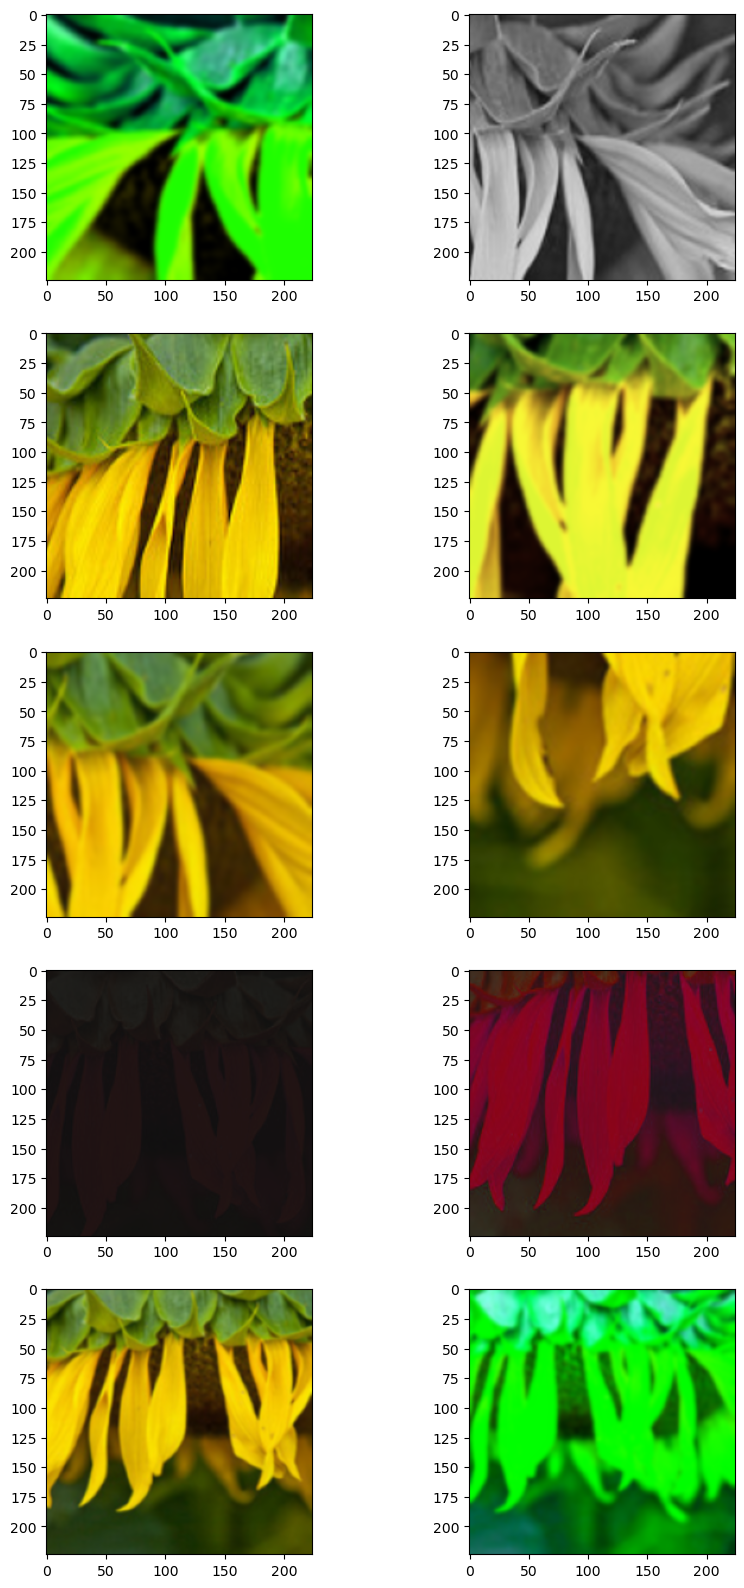

In [14]:
def view_data(image_ds, index):
    plt.figure(figsize=(10,20))
    for i in range(1,6):
        images = image_ds[index]
        view1, view2 = images
        plt.subplot(5,2,2*i-1)
        plt.imshow(view1.permute(1,2,0))
        plt.subplot(5,2,2*i)
        plt.imshow(view2.permute(1,2,0))

view_data(image_ds_train,200)

In [15]:
BATCH_SIZE = config.batch_size # 128 # 16 #128

# Building the data loader(s)
train_loader = torch.utils.data.DataLoader(
    image_ds_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    #num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)

val_loader = torch.utils.data.DataLoader(
    image_ds_val,
    batch_size=BATCH_SIZE,
    shuffle=True,
    #num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)

test_loader = torch.utils.data.DataLoader(
    image_ds_test,
    batch_size=BATCH_SIZE,
    shuffle=False,
    #num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)

In [16]:
print("Batches in TRAIN: ", len(train_loader))
print("Batches in VAL: ", len(val_loader))
print("Batches in TEST: ", len(test_loader))

Batches in TRAIN:  15
Batches in VAL:  3
Batches in TEST:  3


## SimCLR Model

In [17]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

class SimCLR(nn.Module):
    def __init__(self, dropout_p=0.5, embedding_size=128, freeze=False, linear_eval=False):
        super().__init__()
        self.linear_eval = linear_eval
        self.dropout_p = dropout_p
        self.embedding_size = embedding_size
        
        resnet18 = models.resnet18(weights='ResNet18_Weights.DEFAULT') # pre-trained            
        resnet18.fc = Identity()
        self.encoder = resnet18
        
        if freeze:
            for param in self.encoder.parameters():
                param.requires_grad = False

        self.projection = nn.Sequential(
            nn.Linear(512, 256),
            nn.Dropout(p=self.dropout_p),
            nn.ReLU(),
            nn.Linear(256, embedding_size)
        )
        
    def forward(self, x):
        if not self.linear_eval:
            # We expect x to be a list of two views
            # We concatenate both views to be one large batch
            # of size 2*batch_size, i.e., (2*B, C, W, H)
            x = torch.cat(x, dim=0)
        
        encoding = self.encoder(x)
        encoding = encoding.view(encoding.size()[0], -1)
        # If not linear_eval: Projections: (2*B, E), they are concatenated
        # Else: (B, E)
        projection = self.projection(encoding) 
        
        return projection

In [30]:
#model = SimCLR()
#print(model)

## Utils

In [18]:
# Save model function
def save_model(model, save_path):
    torch.save(model.state_dict(), save_path)

# Load model function
def load_model(model, load_path, device):
    model.load_state_dict(torch.load(load_path, map_location=device))
    return model

In [19]:
# Plot training function
def plot_training(train_loss_history, save_path, val_loss_history=None):
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Train Loss')
    if val_loss_history is not None:
        plt.plot(val_loss_history, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(save_path) # config.learning_plot_path
    plt.show()

## Contrastive Loss and Training

In [20]:
def contrastrive_loss(features, config):
    """NT-Xent (Normalized Temperature-Scaled Cross Entropy) Loss,
    aka. Contrastive Loss, used in the SimCLR paper.

    IMPORTANT NOTE: We don't really return the loss, but the logits
    and the (synthetic) labels to compute it with CrossEntropyLoss!

    The main idea behind SimCLR and contrastive learning is to learn
    representations that are close for positive pairs and far for negative pairs.
    In the case of SimCLR, a positive pair is two different augmentations
    of the same image, and a negative pair is two augmentations
    of two different images.

    How NT-Xent works:
    - Compute the cosine similarity between the representations
    of all pairs of images in the batch.
    - Apply a softmax to these similarities, but treat the similarity
    of each image with its positive pair as the correct class.
    This means that for each image, the goal is to make the
    softmax probability of its positive pair as high as possible,
    and the softmax probabilities of its negative pairs as low as possible.
    - Compute the cross entropy between these softmax probabilities
    and the true labels (which have a 1 for the positive pair
    and 0 for the negative pairs).
    - The temperature parameter scales the similarities before the softmax.
    A lower temperature makes the softmax output more peaky
    (i.e., the highest value will be much higher than the others,
    and the lower values will be closer to zero),
    while a higher temperature makes the softmax output more uniform.
    
    Args:
        projections: cat(z1, z2)
        z1: The projection of the first branch/view
        z2: The projeciton of the second branch/view
    
    Returns:
        the NTxent loss

    Notes on the shapes:
        inputs to model (views): [(B, C, W, H), (B, C, W, H)]
            B: batch size
            C: channels
            W: width
            H: height
            E: embedding size
        outputs from model (projections): [2*B, E]
        LABELS: [2*B, 2*B]
        features = outputs from model: [2*B, E]
        mask: [2*B, 2*B]
        similarity_matrix: [2*B, 2*B-1]
        positives: [2*B, 1]
        negatives: [2*B, 2*B-2]
        logits: [2*B, 2*B-1]
        labels: [2*B]
    """
    # FIXME: Refactor: take config out and pass necessary params, remove capital variables, etc.
    # FIXME: convert into class
    BATCH_SIZE = config.batch_size
    DEVICE = config.device
    TEMPERATURE = config.temperature
    
    LABELS = torch.cat([torch.arange(BATCH_SIZE) for i in range(2)], dim=0)
    LABELS = (LABELS.unsqueeze(0) == LABELS.unsqueeze(1)).float() # Creates a one-hot with broadcasting
    LABELS = LABELS.to(DEVICE) # 2*B, 2*B

    similarity_matrix = torch.matmul(features, features.T) # 2*B, 2*B
    # discard the main diagonal from both: labels and similarities matrix
    mask = torch.eye(LABELS.shape[0], dtype=torch.bool).to(DEVICE)
    # ~mask is the negative of the mask
    # the view is required to bring the matrix back to shape
    labels = LABELS[~mask].view(LABELS.shape[0], -1) # 2*B, 2*B-1
    similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1) # 2*B, 2*B-1
    
    # select and combine multiple positives
    positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1) # 2*B, 1

    # select only the negatives
    negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1) # 2*B, 2*B-2

    logits = torch.cat([positives, negatives], dim=1) # 2*B, 2*B-1
    labels = torch.zeros(logits.shape[0], dtype=torch.long).to(DEVICE)

    logits = logits / TEMPERATURE
    
    return logits, labels

In [22]:
# Enabling anomaly detection
# It slows down training! Use it for diagnostics only
#torch.autograd.set_detect_anomaly(True)

model = SimCLR(dropout_p=config.dropout_p, embedding_size=config.embedding_size).to(config.device)
criterion = nn.CrossEntropyLoss().to(config.device)
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
scheduler = StepLR(optimizer, step_size=config.scheduler_step_size, gamma=config.scheduler_gamma)

print(model)

SimCLR(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [21]:
# Validation function
def validate(model, val_loader, criterion, config):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for views in val_loader:
            projections = model([view.to(config.device) for view in views])
            logits, labels = contrastrive_loss(projections, config)
            loss = criterion(logits, labels)
            val_loss += loss.item()
    return val_loss / len(val_loader)

# Training function
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, config, output_freq=2, debug=False):
    model = model.to(config.device)
    train_loss_history = []
    val_loss_history = []
    best_val_loss = float('inf')
    no_improve_epochs = 0
    total_batches = len(train_loader)
    print_every = total_batches // output_freq  # Print every 1/output_freq of total batches

    for epoch in range(config.num_epochs):
        start_time = time.time()
        train_loss = 0.0
        model.train()

        for i, views in enumerate(train_loader):
            projections = model([view.to(config.device) for view in views])
            logits, labels = contrastrive_loss(projections, config)
            if debug and torch.isnan(logits).any() or torch.isinf(logits).any():
                print("[WARNING]: large logits")
                print(logits)
                logits = logits.clamp(min=-10, max=10)  # Adjust these values as necessary
            loss = criterion(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_norm)
            optimizer.step()

            train_loss += loss.item()

            # Print training loss
            if i % print_every == 0:
                print(f"Epoch: {epoch+1}, Batch: {i+1}, Loss: {loss.item()}")

        scheduler.step()
        train_loss /= len(train_loader)
        train_loss_history.append(train_loss)

        val_loss = validate(model, val_loader, criterion, config)
        val_loss_history.append(val_loss)

        end_time = time.time()
        epoch_time = end_time - start_time

        print(f"Epoch: {epoch+1}, Loss: {train_loss}, Val Loss: {val_loss}, Time: {epoch_time}s, Learning Rate: {scheduler.get_last_lr()[0]}")

        # Save last model
        save_model(model, config.last_model_path)    

        # Save best model & early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_model(model, config.best_model_path)
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= config.patience:
                print("Early stopping")
                break

    return train_loss_history, val_loss_history

In [24]:
train_loss_history, val_loss_history = train(model, train_loader, val_loader, criterion, optimizer, scheduler, config)

Epoch: 1, Batch: 1, Loss: 5.3712921142578125
Epoch: 1, Batch: 8, Loss: 4.498214244842529
Epoch: 1, Batch: 15, Loss: 4.3087310791015625
Epoch: 1, Loss: 4.611483351389567, Val Loss: 5.038375536600749, Time: 93.71941900253296s, Learning Rate: 0.001
Epoch: 2, Batch: 1, Loss: 4.252394676208496
Epoch: 2, Batch: 8, Loss: 4.010986804962158
Epoch: 2, Batch: 15, Loss: 3.872483968734741
Epoch: 2, Loss: 4.058132600784302, Val Loss: 4.452065785725911, Time: 91.34593677520752s, Learning Rate: 0.001
Epoch: 3, Batch: 1, Loss: 3.7470216751098633
Epoch: 3, Batch: 8, Loss: 3.7323484420776367
Epoch: 3, Batch: 15, Loss: 3.7005531787872314
Epoch: 3, Loss: 3.806516710917155, Val Loss: 4.5805918375651045, Time: 91.20093822479248s, Learning Rate: 0.001
Epoch: 4, Batch: 1, Loss: 3.8825528621673584
Epoch: 4, Batch: 8, Loss: 3.580227851867676
Epoch: 4, Batch: 15, Loss: 3.8028244972229004
Epoch: 4, Loss: 3.6639533042907715, Val Loss: 5.816879749298096, Time: 90.45922350883484s, Learning Rate: 0.001
Epoch: 5, Batch

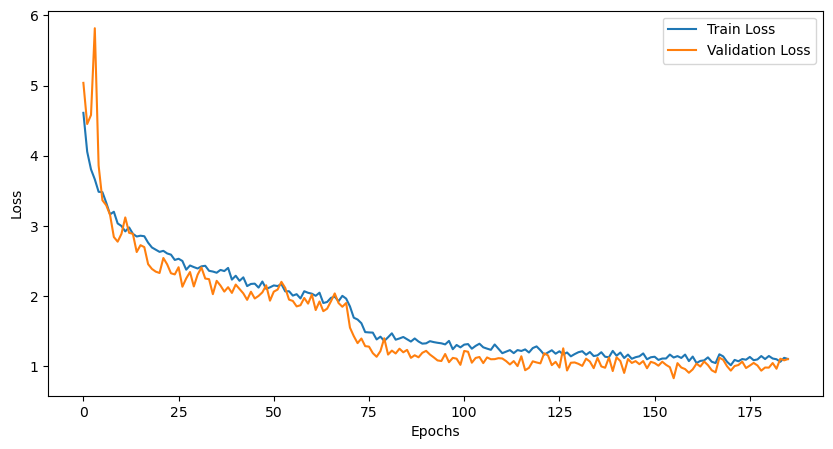

In [26]:
#plot_training(train_loss_history, val_loss_history, config)
plot_training(train_loss_history=train_loss_history,
              save_path=config.learning_plot_path,
              val_loss_history=val_loss_history)

## Downstream Evaluation: Linear Classification Model

In [22]:
def image2tensor(image_paths):
    custom_transform = Compose([
        Resize(255),
        CenterCrop(224),
        ToTensor(),
    ])

    # Always treat the input as a list
    if not isinstance(image_paths, list):
        image_paths = [image_paths]

    tensor_images = []
    for img_path in image_paths:
        img = Image.open(img_path)
        tensor_img = custom_transform(img)
        tensor_images.append(tensor_img)

    # Stack all images into a single tensor
    return torch.stack(tensor_images)

In [23]:
def get_downstream_loader(image_path, batch_size=128):
    custom_transform = Compose([
        Resize(255),
        CenterCrop(224),
        ToTensor(),
    ])

    # We assume the dataset is a classification dataset
    # having each class a dedicated folder
    image_ds = ImageFolder(
        root=image_path,
        transform=custom_transform
    )
    
    num_classes = len(image_ds.classes)
    
    # Building the data loader
    data_loader = torch.utils.data.DataLoader(
        image_ds,
        batch_size=batch_size,
        shuffle=True,
        #num_workers=os.cpu_count(),
        drop_last=True,
        pin_memory=True,
    )

    return num_classes, data_loader

In [24]:
num_classes, data_loader = get_downstream_loader(image_path="../datasets/flowers/train", batch_size=16)

In [25]:
# Validation function
def predict(model, image, device):
    """Prediction of a single image or a batch,
    but without several views, i.e., model.linear_eval = True.

    Args:
        model (SimCLR): SimCLR model
        image (torch.Tensor): shape [B, C, W, H]; of one image, B=1, i.e.,
            use unsqueeze(0)
        device (str): "cpu" or "cuda"
    Returns:
        outputs (torch.Tensor): shape [B, E] or [B, F]
            It depends on the definition of the model (with_projections)
            [B, E]: projections are done in SimCLR
            [B, F]: head is discarded, projections are not done, just features extracted

    Usage:

        simclr_model = SimCLR(dropout_p=config.dropout_p, embedding_size=config.embedding_size).to("cpu")
        simclr_model = load_model(simclr_model, config.best_model_path, "cpu")

        test_images, _ = next(iter(data_loader))
        i = 1
        outputs = predict(simclr_model.to("cpu"), test_images[i].unsqueeze(0), device="cpu")
    
    """
    model.eval()
    model.linear_eval = True
    with torch.no_grad():
        outputs = model(image)
        return outputs

In [26]:
# Load best model
simclr_model = SimCLR(dropout_p=config.dropout_p, embedding_size=config.embedding_size).to("cpu")
simclr_model = load_model(simclr_model, config.best_model_path, "cpu")

# Load one batch, take one image and predict projections
test_images, _ = next(iter(data_loader))
index = 1
print(test_images[index].unsqueeze(0).shape)
outputs = predict(simclr_model.to("cpu"), test_images[index].unsqueeze(0), device="cpu")
print(outputs.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 128])


In [27]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

class LinearEvaluation(nn.Module):
    def __init__(self, model, num_classes, with_projection=False, embedding_size=128):
        super().__init__()
        self.embedding_size = embedding_size
        self.num_classes = num_classes
        self.with_projection = with_projection
        simclr = model
        simclr.linear_eval = True

        # Remove projection is desired (default)
        if not self.with_projection:
            simclr.projection = Identity()
        self.simclr = simclr
        
        for param in self.simclr.parameters():
            param.requires_grad = False

        # Map features/embedding to number of classes
        self.linear = nn.Linear(self.embedding_size, self.num_classes)
        if not self.with_projection:
            # ResNet18 has 512 features prior to head
            self.linear = nn.Linear(512, self.num_classes)
            
    def forward(self, x):
        """This outputs raw logits (and one-hot encoded).
        If we want to use the model for predictions,
        we need to do the following:
            logits = eval_model(image)
            probs = F.softmax(logits, dim=1)
            class_pred = torch.argmax(probs, dim=1)
        """
        encoding = self.simclr(x)
        pred = self.linear(encoding) 
        logits = F.relu(pred)
        
        return logits

In [28]:
# It seems that applying the linear model to the embedding outputs
# yields much better results than ignoring th eembedding projections
# and working with the features - at least in this case
eval_model = LinearEvaluation(simclr_model,
                              num_classes, 
                              with_projection=True,
                              embedding_size=config.embedding_size).to("cpu")
eval_criterion = nn.CrossEntropyLoss().to("cpu")
eval_optimizer = torch.optim.Adam(eval_model.parameters())

In [29]:
def train_downstream_model(model, train_dl, criterion, optimizer, epochs=10, device="cpu", output_freq=2):
    # Initialize the training loss history
    train_loss_history = []

    total_batches = len(train_dl)
    print_every = total_batches // output_freq  # Print every 1/output_freq of total batches

    for epoch in range(epochs):
        start_time = time.time()
        running_loss = 0.0
        epoch_loss = 0.0  # Record the loss for the entire epoch

        for i, (image, label) in enumerate(train_dl):
            image = image.to(device)
            label = label.to(device)
            pred = model(image)
            loss = criterion(pred, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Add the batch loss
            running_loss += loss.item()
            epoch_loss += loss.item()

            # Print running loss every N batches
            if (i+1) % print_every == 0:  
                print(f'Epoch: {epoch+1}, Batch: {i+1}, Running Loss: {running_loss/print_every:.4f}')
                running_loss = 0.0

        # Compute the average loss for this epoch
        avg_epoch_loss = epoch_loss / len(train_dl)
        train_loss_history.append(avg_epoch_loss)

        print(f'Epoch: {epoch+1}, Average Loss: {avg_epoch_loss:.4f}, Time taken: {(time.time()-start_time)/60:.3f} mins')

    return train_loss_history

In [117]:
train_loss_history = train_downstream_model(eval_model,
                                            data_loader,
                                            eval_criterion,
                                            eval_optimizer,
                                            epochs=30,
                                            device="cpu",
                                            output_freq=5)

Epoch: 1, Batch: 34, Running Loss: 1.5745
Epoch: 1, Batch: 68, Running Loss: 1.3836
Epoch: 1, Batch: 102, Running Loss: 1.1806
Epoch: 1, Batch: 136, Running Loss: 0.9974
Epoch: 1, Batch: 170, Running Loss: 0.8590
Epoch: 1, Average Loss: 1.1967, Time taken: 4.258 mins
Epoch: 2, Batch: 34, Running Loss: 0.7829
Epoch: 2, Batch: 68, Running Loss: 0.7016
Epoch: 2, Batch: 102, Running Loss: 0.6501
Epoch: 2, Batch: 136, Running Loss: 0.6563
Epoch: 2, Batch: 170, Running Loss: 0.6324
Epoch: 2, Average Loss: 0.6835, Time taken: 4.213 mins
Epoch: 3, Batch: 34, Running Loss: 0.5931
Epoch: 3, Batch: 68, Running Loss: 0.5654
Epoch: 3, Batch: 102, Running Loss: 0.5303
Epoch: 3, Batch: 136, Running Loss: 0.5658
Epoch: 3, Batch: 170, Running Loss: 0.5268
Epoch: 3, Average Loss: 0.5548, Time taken: 4.258 mins
Epoch: 4, Batch: 34, Running Loss: 0.5408
Epoch: 4, Batch: 68, Running Loss: 0.4858
Epoch: 4, Batch: 102, Running Loss: 0.4836
Epoch: 4, Batch: 136, Running Loss: 0.5233
Epoch: 4, Batch: 170, Runn

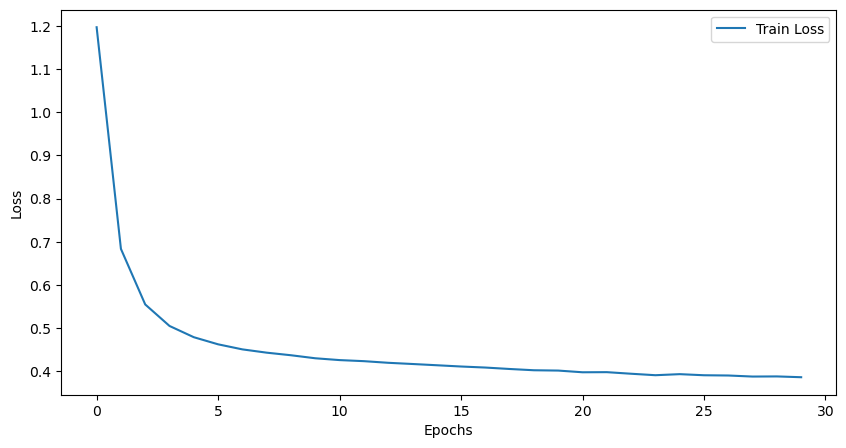

In [118]:
plot_training(train_loss_history=train_loss_history,
              save_path="./output_flowers/downstream_learning_curve.png",
              val_loss_history=None)

In [30]:
# Save linear evaluatoion model
linear_eval_model_path = os.path.join(config.base_path, "linear_eval_model.pth")

In [ ]:
save_model(eval_model.to("cpu"), save_path=linear_eval_model_path)

In [31]:
# Load best SimCLR model
simclr_model = SimCLR(dropout_p=config.dropout_p, embedding_size=config.embedding_size).to("cpu")
simclr_model = load_model(simclr_model, config.best_model_path, "cpu")
# Load saved eval model
eval_model = LinearEvaluation(simclr_model,
                              num_classes, # obtained with get_downstream_loader
                              with_projection=True,
                              embedding_size=config.embedding_size).to("cpu")
eval_model = load_model(eval_model, linear_eval_model_path, "cpu")

In [32]:
def evaluate_downstream_model(dataloader, model, device, num_classes):
    model.eval()
    
    all_preds = []
    all_labels = []

    # Inference
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            labels = labels.to(device)
            
            preds = model(images)
            _, preds = torch.max(preds, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)

    # Calculate per-class accuracy
    cm = confusion_matrix(all_labels, all_preds)
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    class_names = dataloader.dataset.classes
    class_accuracy = {class_names[i]: acc for i, acc in enumerate(class_accuracy)}

    # Normalize the confusion matrix for visualization
    #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    return {
        "accuracy": accuracy,
        "class_accuracies": class_accuracy,
        "confusion_matrix": cm,
    }


In [141]:
eval_dict = evaluate_downstream_model(data_loader, eval_model, "cpu", num_classes)
print(eval_dict)

Evaluating: 100%|████████████████████████████████████████████████████████████████████| 171/171 [03:35<00:00,  1.26s/it]

{'accuracy': 0.8695175438596491, 'class_accuracies': {'daisy': 0.88, 'dandelion': 0.9069767441860465, 'rose': 0.8268839103869654, 'sunflower': 0.8987854251012146, 'tulip': 0.8316831683168316}, 'confusion_matrix': array([[440,  31,   6,  11,  12],
       [ 21, 585,  14,  12,  13],
       [  9,  12, 406,   7,  57],
       [ 17,  15,  11, 444,   7],
       [ 14,  14,  62,  12, 504]], dtype=int64)}


In [142]:
def plot_confusion_matrix(confusion_matrix, class_names):
    plt.figure(figsize = (7,5))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

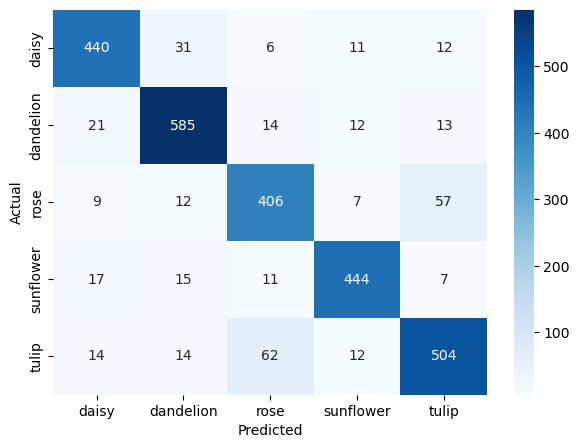

In [143]:
class_names = data_loader.dataset.classes
plot_confusion_matrix(eval_dict["confusion_matrix"], class_names)

## Downstream Evaluation: Similarity Distributions

In this evaluation approach, I will perform the following tasks:

- Compute the embedding vectors of all images
- Predict the class of each image using the downstream linear evaluation model
- Extract all additional information: filename, file path, label (class name)
- Compute a basic clustering with k-means and the elbow method
- Manifold learning: T-SNE with color-coding
    - With predicted classes
    - With class labels
    - With cluster ids
- PCA to see if we could compress the embeddings (reduce dimensionality)
- Similarity distributions and threshold detection
    - With predicted classes
    - With class labels
    - With cluster ids

In [164]:
def extract_class_and_filename(file_path):
    path_parts = os.path.normpath(file_path).split(os.sep)
    class_name = path_parts[-2]  # class name is the second to last part
    file_name = path_parts[-1]  # file name is the last part
    return class_name, file_name

file_paths = list_images[:5]
for file_path in file_paths:
    class_name, file_name = extract_class_and_filename(file_path)
    print(f"Class Name: {class_name}, File Name: {file_name}")

Class Name: daisy, File Name: 10140303196_b88d3d6cec.jpg
Class Name: daisy, File Name: 10172379554_b296050f82_n.jpg
Class Name: daisy, File Name: 10172567486_2748826a8b.jpg
Class Name: daisy, File Name: 10172636503_21bededa75_n.jpg
Class Name: daisy, File Name: 10391248763_1d16681106_n.jpg


In [248]:
def generate_image_vector_dataset(simclr_model, eval_model, list_image_paths, class_names, device="cpu"):
    """Take all image paths and feed them to the SimCLR model
    and the linear evaluation model to obtain the embedding/feature vector
    and the predicted class of the linear evaluation model.
    
    Instead of doing it with a data loader, it is done in a loop
    to have more flexibility in future applications.
    
    Along with the aforementioned values, labels and filename
    information is retreived.
    
    Everything is packed into a Pandas dataframe."""
    simclr_model.eval()
    eval_model.eval()

    name2id = {class_names[i]:i for i in range(len(class_names))}

    filepaths = []
    filenames = []
    embeddings = []
    labels = []
    predictions = []

    # Embedding predictions: no concatenation of views
    simclr_model.linear_eval = True
    
    with torch.no_grad():
        for filepath in tqdm(list_image_paths, desc="Computing vectors and linear predictions"):
            image = image2tensor(filepath)
            class_name, file_name = extract_class_and_filename(filepath)
            class_id = name2id[class_name]
            image = image.to(device)

            # Predict
            embedding = simclr_model(image)
            logits = eval_model(image)
            probs = F.softmax(logits, dim=1)
            class_pred = torch.argmax(probs, dim=1)
            
            filepaths.append(filepath)
            filenames.append(file_name)
            embeddings.append(embedding.squeeze(0).cpu().numpy().tolist())
            predictions.append(class_names[class_pred.squeeze(0).cpu().item()])
            labels.append(class_name)

    df = pd.DataFrame({
        'filename': filenames,
        'filepath': filepaths,
        'label': labels,
        'linear_pred': predictions,
        'embedding': embeddings,
    })

    return df

In [189]:
df = generate_image_vector_dataset(simclr_model, eval_model, list_images, class_names)

Computing vectors and linear predictions: 100%|████████████████████████████████████| 2746/2746 [12:36<00:00,  3.63it/s]


In [3]:
vectors_dataset_path = os.path.join(config.base_path, "vectors_dataset.csv")

In [ ]:
df.to_csv(vectors_dataset_path, sep=',', header=True, index=False)

In [4]:
df = pd.read_csv(vectors_dataset_path)
df['embedding'] = df['embedding'].apply(ast.literal_eval)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2746 entries, 0 to 2745
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   filename     2746 non-null   object
 1   filepath     2746 non-null   object
 2   label        2746 non-null   object
 3   linear_pred  2746 non-null   object
 4   embedding    2746 non-null   object
 5   cluster      2746 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 128.8+ KB


In [6]:
df.head()

filename  \
0    10140303196_b88d3d6cec.jpg   
1  10172379554_b296050f82_n.jpg   
2    10172567486_2748826a8b.jpg   
3  10172636503_21bededa75_n.jpg   
4  10391248763_1d16681106_n.jpg   

                                            filepath  label linear_pred  \
0  ../datasets/flowers/train\daisy\10140303196_b8...  daisy       daisy   
1  ../datasets/flowers/train\daisy\10172379554_b2...  daisy       daisy   
2  ../datasets/flowers/train\daisy\10172567486_27...  daisy       daisy   
3  ../datasets/flowers/train\daisy\10172636503_21...  daisy       daisy   
4  ../datasets/flowers/train\daisy\10391248763_1d...  daisy       daisy   

                                           embedding  cluster  
0  [-0.5338386297225952, -0.7343480587005615, 0.3...        2  
1  [0.058685123920440674, -1.1110296249389648, 0....        1  
2  [-0.2931477725505829, -1.0281589031219482, 0.0...        2  
3  [-0.8797124624252319, -0.700323760509491, -0.0...        1  
4  [0.512474000453949, -0.4610719680786133, 0.934...        1

### Basic K-Means Clustering and Manifold Learning

In [7]:
X = np.vstack(df['embedding'].values)

In [8]:
X.shape

(2746, 128)

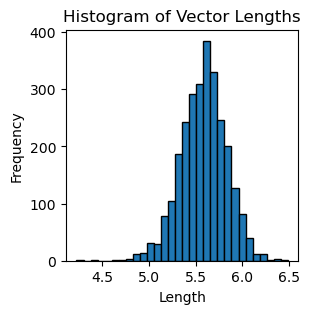

In [9]:
# Compute the length of each row in X
lengths = np.linalg.norm(X, axis=1)

# Create a histogram of the lengths
plt.figure(figsize=(3,3))
plt.hist(lengths, bins=30, edgecolor='black')
plt.title('Histogram of Vector Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

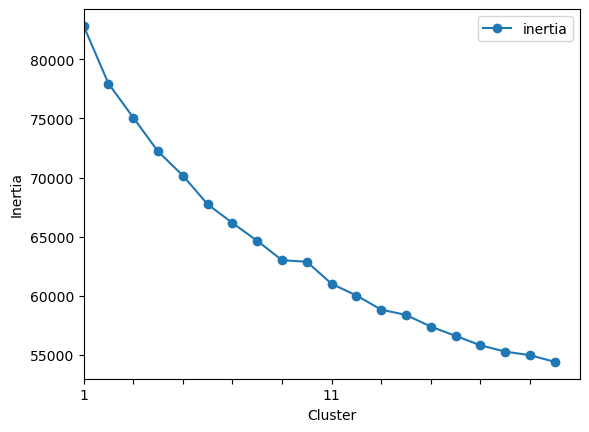

In [10]:
# We apply K-Means without a known number of clusters,
# i.e., we use the elbow method
# Create and fit a range of models
km_list = list()
max_clusters = 20
for n_clusters in range(1,max_clusters+1):
    km = KMeans(n_clusters=n_clusters,
                n_init='auto',
                random_state=42)
    km = km.fit(X)
    km_list.append(pd.Series({'clusters': n_clusters, 
                              'inertia': km.inertia_,
                              'model': km}))

plot_data = (pd.concat(km_list, axis=1)
             .T
             [['clusters','inertia']]
             .set_index('clusters'))

ax = plot_data.plot(marker='o',ls='-')
ax.set_xticks(range(0,max_clusters,2))
ax.set_xlim(0,max_clusters)
ax.set(xlabel='Cluster', ylabel='Inertia');

In [11]:
# Select a k value
n_clusters = 5 # There are 5 classes of flowers
km = KMeans(n_clusters=n_clusters,
            n_init='auto',
            random_state=42)
km = km.fit(X)

# We create a new column with the prediction
clusters = km.predict(X)

In [12]:
# Save?
df["cluster"] = clusters
#df.to_csv(vectors_dataset_path, sep=',', header=True, index=False)
#df = pd.read_csv(vectors_dataset_path)
#df['embedding'] = df['embedding'].apply(ast.literal_eval)

In [13]:
df.head()

filename  \
0    10140303196_b88d3d6cec.jpg   
1  10172379554_b296050f82_n.jpg   
2    10172567486_2748826a8b.jpg   
3  10172636503_21bededa75_n.jpg   
4  10391248763_1d16681106_n.jpg   

                                            filepath  label linear_pred  \
0  ../datasets/flowers/train\daisy\10140303196_b8...  daisy       daisy   
1  ../datasets/flowers/train\daisy\10172379554_b2...  daisy       daisy   
2  ../datasets/flowers/train\daisy\10172567486_27...  daisy       daisy   
3  ../datasets/flowers/train\daisy\10172636503_21...  daisy       daisy   
4  ../datasets/flowers/train\daisy\10391248763_1d...  daisy       daisy   

                                           embedding  cluster  
0  [-0.5338386297225952, -0.7343480587005615, 0.3...        2  
1  [0.058685123920440674, -1.1110296249389648, 0....        1  
2  [-0.2931477725505829, -1.0281589031219482, 0.0...        2  
3  [-0.8797124624252319, -0.700323760509491, -0.0...        1  
4  [0.512474000453949, -0.4610719680786133, 0.934...        1

In [14]:
tsne = TSNE(n_components=2,
            verbose=1,
            random_state=42)
z = tsne.fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2746 samples in 0.001s...
[t-SNE] Computed neighbors for 2746 samples in 0.091s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2746
[t-SNE] Computed conditional probabilities for sample 2000 / 2746
[t-SNE] Computed conditional probabilities for sample 2746 / 2746
[t-SNE] Mean sigma: 2.014316
[t-SNE] KL divergence after 150 iterations with early exaggeration: 83.091133
[t-SNE] KL divergence after 1000 iterations: 1.845808


[Text(0.5, 1.0, 'Embedding vector T-SNE projection - predicted CLUSTERS')]

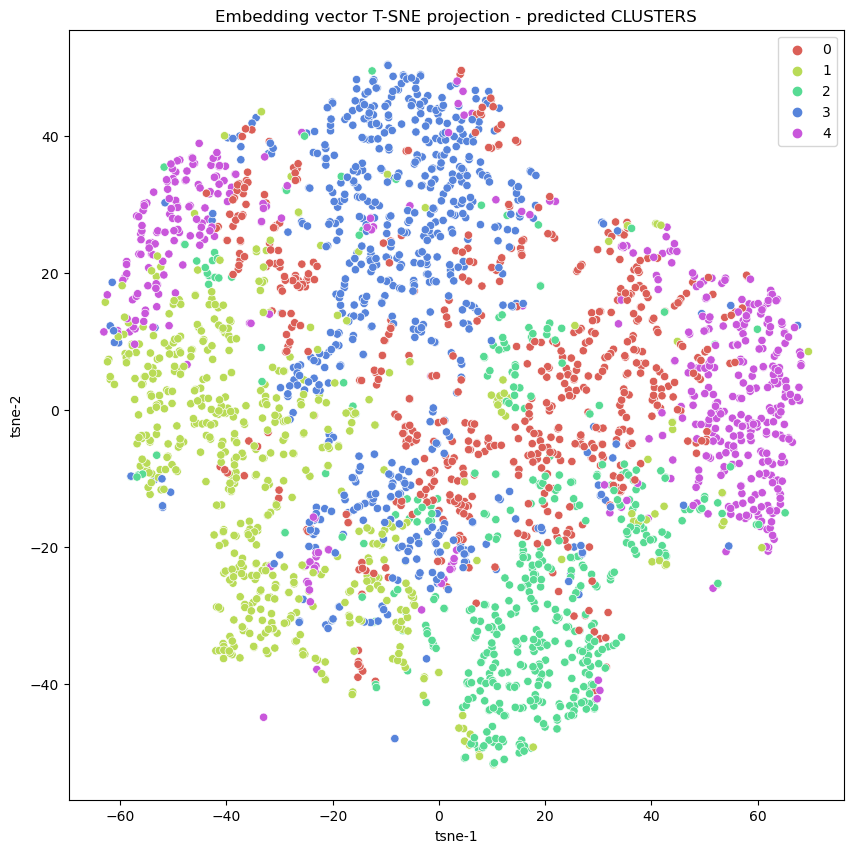

In [15]:
# Plot clusters
df_tsne = pd.DataFrame()
df_tsne["y"] = df["cluster"] # clusters
df_tsne["tsne-1"] = z[:,0]
df_tsne["tsne-2"] = z[:,1]
plt.figure(figsize=(10,10))
sns.scatterplot(x="tsne-1", y="tsne-2",
                hue=df_tsne.y.tolist(),
                palette=sns.color_palette("hls", len(df_tsne["y"].unique())),
                data=df_tsne).set(title="Embedding vector T-SNE projection - predicted CLUSTERS")

[Text(0.5, 1.0, 'Embedding vector T-SNE projection - LABELS')]

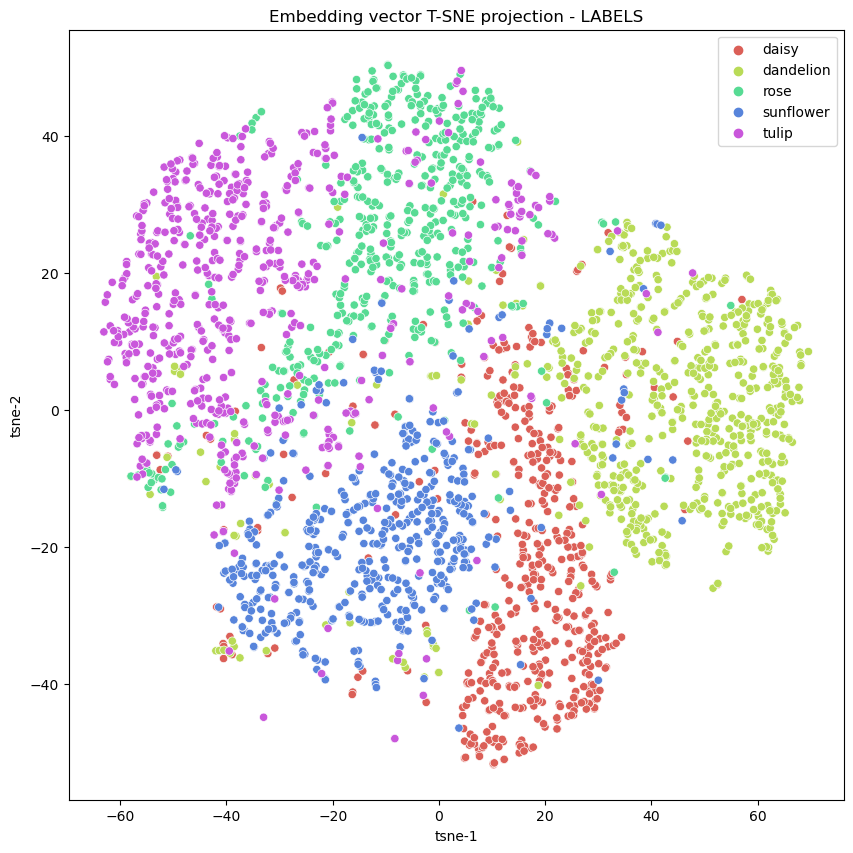

In [16]:
# Plot labels
df_tsne = pd.DataFrame()
df_tsne["y"] = df["label"]
df_tsne["tsne-1"] = z[:,0]
df_tsne["tsne-2"] = z[:,1]
plt.figure(figsize=(10,10))
sns.scatterplot(x="tsne-1", y="tsne-2",
                hue=df_tsne.y.tolist(),
                palette=sns.color_palette("hls", len(df_tsne["y"].unique())),
                data=df_tsne).set(title="Embedding vector T-SNE projection - LABELS")

[Text(0.5, 1.0, 'Embedding vector T-SNE projection - predicted CLASSES')]

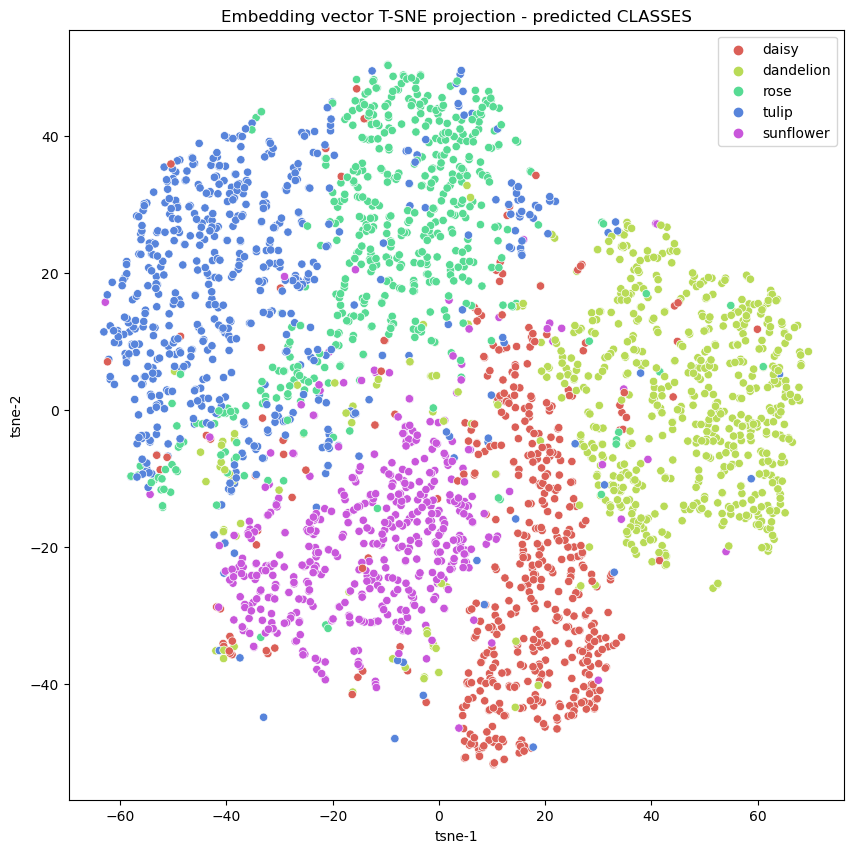

In [17]:
# Plot predicted classes
df_tsne = pd.DataFrame()
df_tsne["y"] = df["linear_pred"]
df_tsne["tsne-1"] = z[:,0]
df_tsne["tsne-2"] = z[:,1]
plt.figure(figsize=(10,10))
sns.scatterplot(x="tsne-1", y="tsne-2",
                hue=df_tsne.y.tolist(),
                palette=sns.color_palette("hls", len(df_tsne["y"].unique())),
                data=df_tsne).set(title="Embedding vector T-SNE projection - predicted CLASSES")

### PCA of Embedding Dimensionality

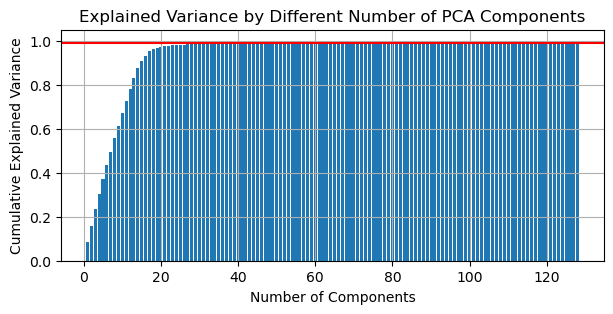

The number of components needed to reach 99.0% variance is: 37


37

In [18]:
def pca_explained_variance_plot(X, threshold=0.95):
    pca = PCA()
    pca.fit(X)

    explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
    
    plt.figure(figsize=(7, 3))
    plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
    plt.axhline(y=threshold, color='r', linestyle='-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance by Different Number of PCA Components')
    plt.grid(True)
    plt.show()
    
    num_components = np.where(explained_variance_ratio >= threshold)[0][0] + 1
    print(f"The number of components needed to reach {threshold*100}% variance is: {num_components}")
    return num_components

pca_explained_variance_plot(X, 0.99)

### Similarity Distributions

Number of positive pairs:  761583
Number of negative pairs:  3007302
Best threshold:  inf


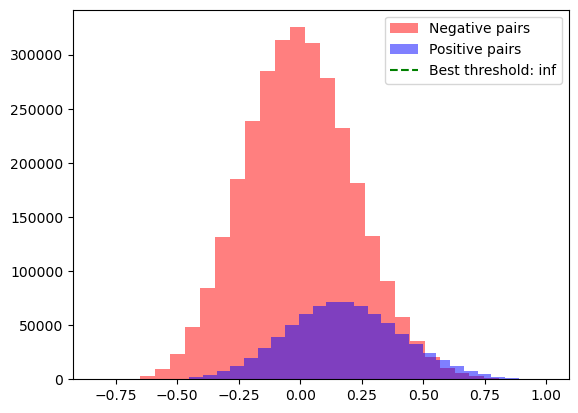

In [292]:
def compute_similarity_distribution_plot(X, y):
    positive_sims = []
    negative_sims = []
    Xn = normalize(X, axis=1)
    n = X.shape[0]
    for i in range(n):
        x_i = Xn[i,:]
        y_i = y[i]
        for j in range(i+1,n):
            x_j = Xn[j,:]
            y_j = y[j]
            if y_i == y_j:
                positive_sims.append(np.dot(x_i, x_j.T))
            else:
                negative_sims.append(np.dot(x_i, x_j.T))

    print("Number of positive pairs: ", len(positive_sims))
    print("Number of negative pairs: ", len(negative_sims))

    # Compute best threshold
    similarities = positive_sims + negative_sims
    labels = np.array([1]*len(positive_sims) + [0]*len(negative_sims))
    fpr, tpr, thresholds = roc_curve(labels, similarities, pos_label=0)
    best_threshold = thresholds[np.argmax(tpr - fpr)]

    print("Best threshold: ", best_threshold)

    # Compute histograms
    plt.hist(negative_sims, bins=30, alpha=0.5, color='r', label='Negative pairs')
    plt.hist(positive_sims, bins=30, alpha=0.5, color='b', label='Positive pairs')
    
    # Plot best threshold
    plt.axvline(x=best_threshold, color='g', linestyle='--', label=f'Best threshold: {best_threshold:.2f}')
    plt.legend()
    plt.show()

    return best_threshold

X = np.vstack(df['embedding'].values)
#y = df['label']
y = df['cluster']
best_threshold = compute_similarity_distribution_plot(X, y)

### Similarity Matrix

In [19]:
def compute_similarity_matrix(df, embedding_col="embedding"):
    X = np.vstack(df['embedding'].values)
    Xn = normalize(X, axis=1)
    S = np.matmul(Xn, Xn.T)

    return S

In [20]:
def get_top_k_similar_items(similarity_matrix, index, k=10):
    # Given an index i (a document/row), the top k
    # most similar documents: their indices (top_k_ind)
    # and their similarity values (top_k_values)
    # Note: the first index should always be i itself,
    # because it is the diagonal index for i
    # NOTE: normalization?
    k = k + 1  # because the item itself will be included
    row_i = similarity_matrix[index, :]
    ind = np.argpartition(row_i, -k)[-k:]
    top_k_indices = ind[np.argsort(row_i[ind])][::-1][1:].tolist()  # sorting indices according to their corresponding values
    top_k_values = row_i[top_k_indices].tolist()

    return top_k_indices, top_k_values

In [21]:
S = compute_similarity_matrix(df)
S.shape

(2746, 2746)

In [23]:
top_k_indices, top_k_values = get_top_k_similar_items(S, index=1, k=10)
print("top_k_indices: ", top_k_indices)
print("top_k_values: ", top_k_values)

top_k_indices:  [785, 556, 902, 2293, 1361, 2, 225, 1495, 1534, 1634]
top_k_values:  [0.8147144556076299, 0.7635542155707987, 0.7032604245473919, 0.7005144767805579, 0.6958317146600066, 0.6940819262165924, 0.6898183200770185, 0.6573404517341291, 0.6568762776757339, 0.6533509150896957]


In [26]:
"""
def plot_most_similar_items(df, item, similarity_matrix, k=10, filename_col="filename", filepath_col="filepath", label_col="label"):
    index = 0
    if isinstance(item, str):
        index = df.loc[df[filename_col]==item].index[0]
    filepath = df.iloc[index][filepath_col]

    top_k_indices, top_k_values = get_top_k_similar_items(similarity_matrix, index, k)

    # Create main figure and subplots layout
    fig = plt.figure(figsize=(5, 10))  # Modify as needed
    gs = gridspec.GridSpec(7, 2)  # 7 rows, 2 columns

    # Plotting target image
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # cv2 reads images in BGR format by default

    ax = plt.subplot(gs[0:2, :])  # Spanning entire width for first two rows
    ax.imshow(img)
    ax.axis('off')
    ax.set_title("Target Image", fontsize=14)

    # Plotting similar images in 2 columns
    for i, idx in enumerate(top_k_indices):
        row = (i // 2) + 2  # +2 to skip first two rows
        col = i % 2
        similar_filepath = df.iloc[idx][filepath_col]
        label = df.iloc[idx][label_col]
        img = cv2.imread(similar_filepath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # cv2 reads images in BGR format by default

        ax = plt.subplot(gs[row, col])
        ax.imshow(img)
        ax.axis('off')
        ax.set_title("Label: {}\nSimilarity: {:.2f}".format(label, top_k_values[i]), fontsize=12)

    plt.tight_layout()
    plt.show()
"""
def plot_most_similar_items(df, item, similarity_matrix,
                            k=10,
                            filename_col="filename",
                            filepath_col="filepath",
                            label_col="label"):
    index = 0
    if isinstance(item, str):
        index = df.loc[df[filename_col]==item].index[0]
    else:
        index = item
    filepath = df.iloc[index][filepath_col]
    target_label = df.iloc[index][label_col]
    filename = df.iloc[index][filename_col]
    
    top_k_indices, top_k_values = get_top_k_similar_items(similarity_matrix, index, k)

    # Create main figure and subplots layout
    fig = plt.figure(figsize=(8, 25))  # Modify as needed
    gs = gridspec.GridSpec(7, 2)  # 7 rows, 2 columns

    # Plotting target image
    img = Image.open(filepath)

    ax = plt.subplot(gs[0:2, :])  # Spanning entire width for first two rows
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Target Image - Label: {target_label}\nFilename: {filename}", fontsize=14)
    
    # Plotting similar images in 2 columns
    for i, idx in enumerate(top_k_indices):
        row = (i // 2) + 2  # +2 to skip first two rows
        col = i % 2
        similar_filepath = df.iloc[idx][filepath_col]
        label = df.iloc[idx][label_col]
        filename = df.iloc[idx][filename_col]
        img = Image.open(similar_filepath)

        ax = plt.subplot(gs[row, col])
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Label: {label}\nFilename: {filename}\nSimilarity: {top_k_values[i]:.2f}", fontsize=12)

    plt.tight_layout()
    plt.show()

In [29]:
df.label.unique()

array(['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'], dtype=object)

In [38]:
#df[df.label=="daisy"].head()
#df[df.label=="dandelion"].head()
#df[df.label=="rose"].head()
#df[df.label=="sunflower"].head()
df[df.label=="tulip"].head()

filename  \
2139    10094729603_eeca3f2cb6.jpg   
2140    10094731133_94a942463c.jpg   
2141    10128546863_8de70c610d.jpg   
2142  10163955604_ae0b830975_n.jpg   
2143    10164073235_f29931d91e.jpg   

                                               filepath  label linear_pred  \
2139  ../datasets/flowers/train\tulip\10094729603_ee...  tulip       tulip   
2140  ../datasets/flowers/train\tulip\10094731133_94...  tulip        rose   
2141  ../datasets/flowers/train\tulip\10128546863_8d...  tulip       tulip   
2142  ../datasets/flowers/train\tulip\10163955604_ae...  tulip       tulip   
2143  ../datasets/flowers/train\tulip\10164073235_f2...  tulip       tulip   

                                              embedding  cluster  
2139  [0.012036740779876709, -0.09591799974441528, 0...        1  
2140  [-0.49900364875793457, -0.015235871076583862, ...        1  
2141  [0.7583109140396118, -0.21940526366233826, -0....        1  
2142  [0.007524609565734863, 0.2511191666126251, 0.1...        1  
2143  [0.1539894938468933, 0.18543311953544617, 0.25...        1

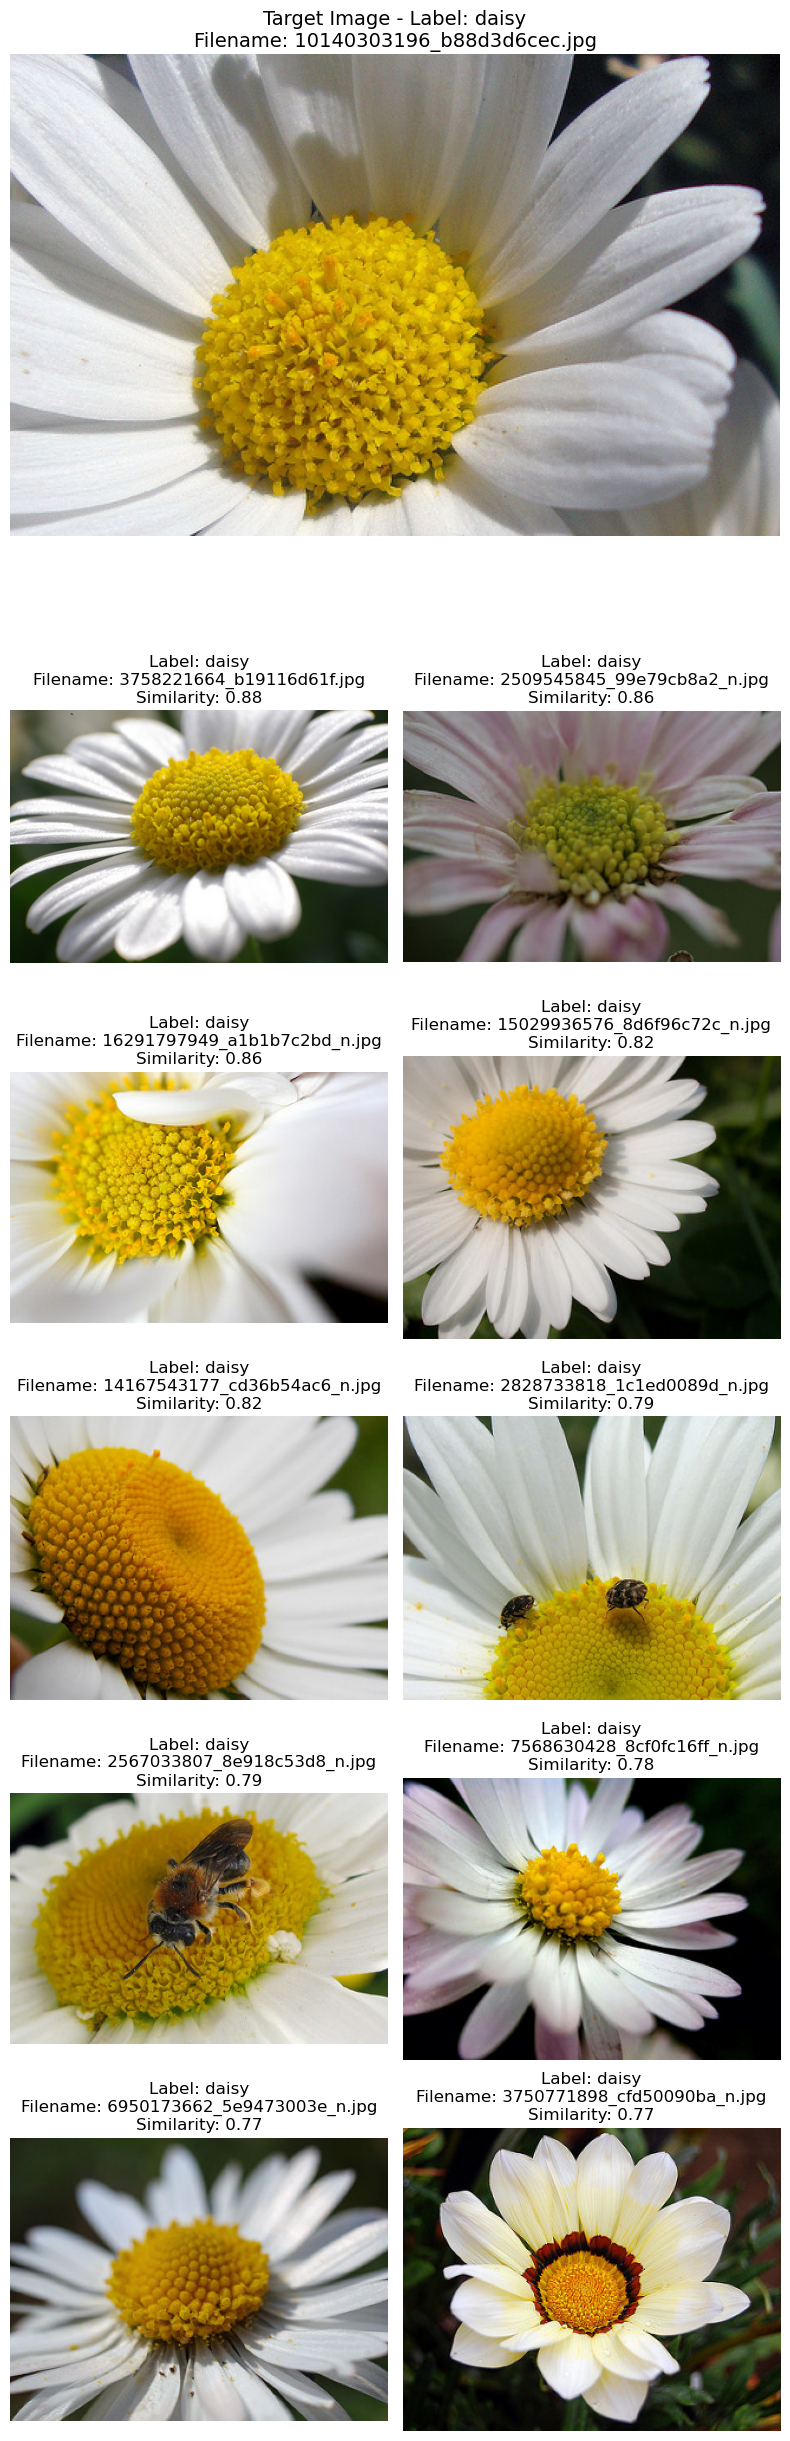

In [40]:
#plot_most_similar_items(df, 0, S, 10)
plot_most_similar_items(df, "10140303196_b88d3d6cec.jpg", S, 10)
#plot_most_similar_items(df, "10043234166_e6dd915111_n.jpg", S, 10)
#plot_most_similar_items(df, "10090824183_d02c613f10_m.jpg", S, 10)
#plot_most_similar_items(df, "10386503264_e05387e1f7_m.jpg", S, 10)
#plot_most_similar_items(df, "10094729603_eeca3f2cb6.jpg", S, 10)